In [1]:
!pip install hyperopt
!pip install tensorflow

In [2]:
# Load libraries

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import warnings

warnings.filterwarnings('ignore')

In [3]:
#Load data

data = pd.read_csv('breast-cancer 2.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
#Dataframe summary

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
# Encode the diagnosis column

label_encoder = LabelEncoder()
data['diagnosis'] = label_encoder.fit_transform(data['diagnosis'])

In [6]:
# Select only numeric columns

numeric_data = data.select_dtypes(include=[float, int])

In [7]:
## Data cleaning: Duplicates

initial_row_count = data.shape[0]
data = data.drop_duplicates()
final_row_count = data.shape[0]
duplicates_removed = initial_row_count - final_row_count
print(f"Number of duplicates removed: {duplicates_removed}")

Number of duplicates removed: 0


In [8]:
## Data cleaning: Missing values

missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [9]:
# Data cleaning: Outliers. Identify outliers using the IQR method

Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1
outliers = (numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))

In [10]:
# Create a boolean mask for outliers

outlier_mask = outliers.any(axis=1)

# Remove outliers

cleaned_data = data.loc[~outlier_mask]

Training set size (X_train): (276, 31)
Training set size (y_train): (276,)
Testing set size (X_test): (70, 31)
Testing set size (y_test): (70,)


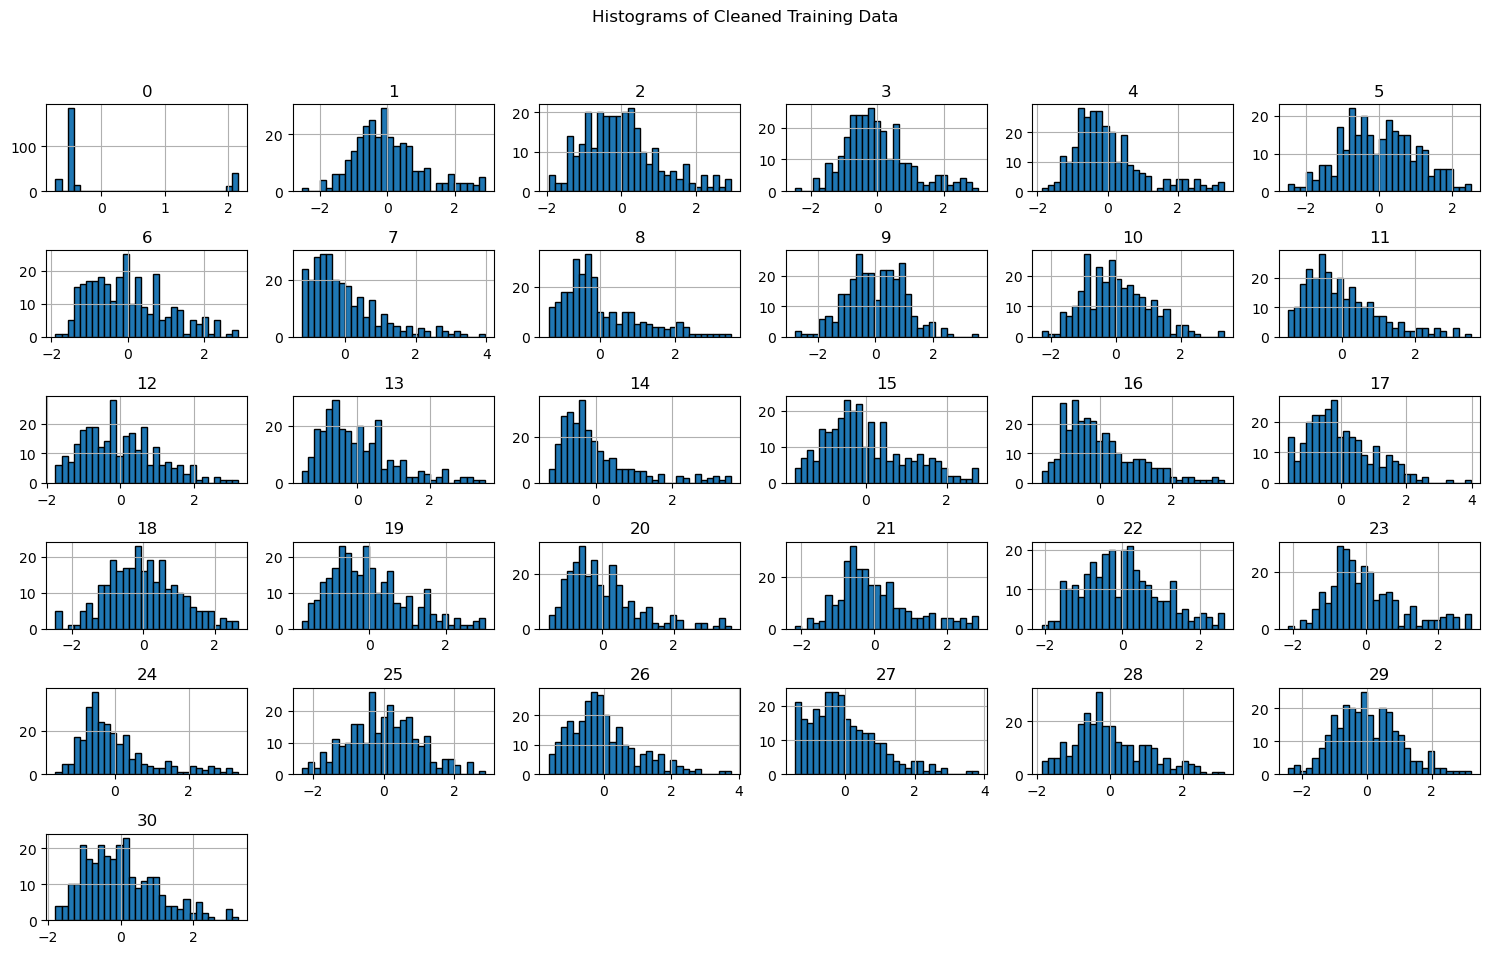

In [11]:
# Split the data into training and testing sets
X = cleaned_data.drop('diagnosis', axis=1)
y = cleaned_data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verify the split by printing dimensions
print("Training set size (X_train):", X_train.shape)
print("Training set size (y_train):", y_train.shape)
print("Testing set size (X_test):", X_test.shape)
print("Testing set size (y_test):", y_test.shape)

# Plot histograms for each numeric column in the cleaned training data
pd.DataFrame(X_train).hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Cleaned Training Data')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
def create_model(params):
    # Create a neural network model
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    # Hidden layers
    for _ in range(params['num_layers']):
        model.add(layers.Dense(params['units'], activation=params['activation']))
        model.add(layers.Dropout(params['dropout']))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=params['optimizer'], 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

def objective(params):
    # Build the model
    model = create_model(params)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=20, 
                        batch_size=params['batch_size'],
                        validation_split=0.2, 
                        verbose=0)
    
    # Evaluate the model
    accuracy = max(history.history['val_accuracy'])
    
    # Return the negative accuracy as we want to minimize the loss
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the search space for hyperparameters
space = {
    'num_layers': hp.choice('num_layers', [1, 2, 3]),
    'units': hp.choice('units', [32, 64, 128]),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop']),
    'dropout': hp.uniform('dropout', 0, 0.5),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

# Perform Bayesian Optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best parameters found: ", best)


100%|████████| 50/50 [00:28<00:00,  1.76trial/s, best loss: -0.9821428656578064]
Best parameters found:  {'activation': 0, 'batch_size': 1, 'dropout': 0.18005044812237142, 'num_layers': 2, 'optimizer': 0, 'units': 0}


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.8702 - loss: 0.4081
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.9717 - loss: 0.0827
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.9627 - loss: 0.0876
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.9826 - loss: 0.0561
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.9811 - loss: 0.0460
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.9799 - loss: 0.0402
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.9996 - loss: 0.0198
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.9862 - loss: 0.0369
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.9990 - loss: 0.0115  
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.9988 - loss: 0.0126
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.9958 - loss: 0.0120
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/st

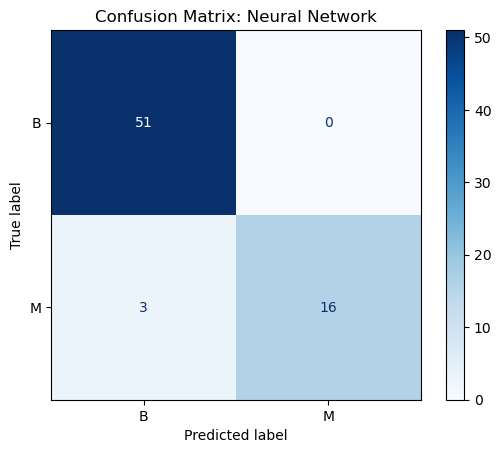

In [14]:
# Convert hyperopt results to keras compatible format
best_params = {
    'num_layers': best['num_layers'] + 1,
    'units': [32, 64, 128][best['units']],
    'activation': ['relu', 'tanh'][best['activation']],
    'optimizer': ['adam', 'rmsprop'][best['optimizer']],
    'dropout': best['dropout'],
    'batch_size': [16, 32, 64][best['batch_size']]
}

# Build the final model with the best parameters
final_model = create_model(best_params)

# Train the final model
final_model.fit(X_train, y_train, epochs=50, batch_size=best_params['batch_size'], verbose=1)

# Predict on the test set
y_pred = (final_model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
misclassification_rate = 1 - accuracy
sensitivity = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Misclassification Rate: {misclassification_rate:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: Neural Network")
plt.show()
